In [104]:
import os
import numpy as np
import pandas as pd

import pmdarima as pm
from arch import arch_model
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [105]:
print(os.getcwd())
os.system(f'python ./1_data_prepro.py')


/Users/yanting/OneDrive/Desktop/23_24 WS (Master)/VL - PTSFC/2023_11-PTSFC


cwd = /Users/yanting/OneDrive/Desktop/23_24 WS (Master)/VL - PTSFC/2023_11-PTSFC


0

In [106]:
today = datetime.today().strftime("%Y-%m-%d")
fname = f"2000-01-01_{today}_dax_returns.csv"

# Load data
ret_df = pd.read_csv(f"./data/{fname}", index_col=0)
ret_df.index = pd.to_datetime(ret_df.index)
ret_df.head()

,ret1,ret2,ret3,ret4,ret5
2000-01-10,2.109446,6.727690,6.309258,5.012269,2.555809
2000-01-11,-0.496065,1.613381,6.231625,5.813193,4.516204
2000-01-12,0.312373,-0.183692,1.925754,6.543998,6.125566
2000-01-13,0.622550,0.934923,0.438858,2.548304,7.166548
2000-01-14,3.075296,3.697846,4.010219,3.514153,5.623600


### Look at Data

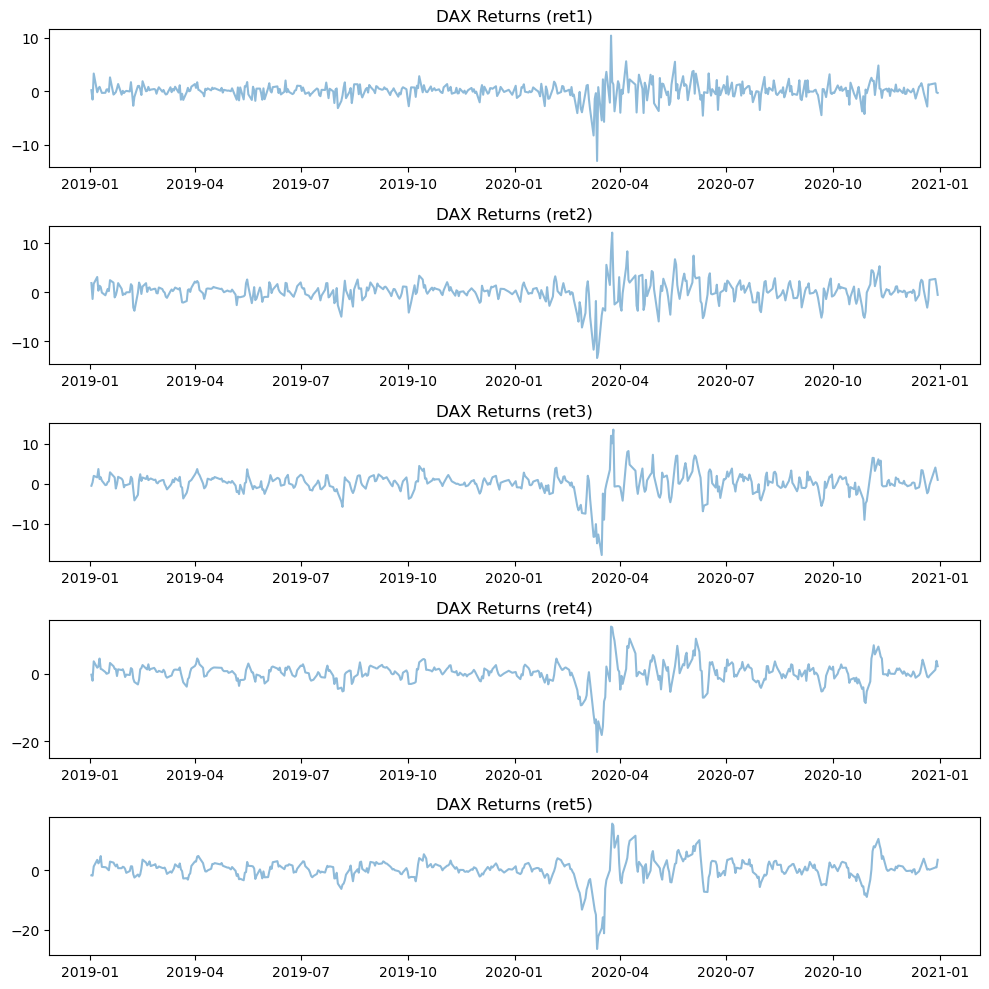

In [107]:
start_yr = 2019
end_yr = 2020
filtered_df = ret_df[(ret_df.index.year >= start_yr) & (ret_df.index.year <= end_yr)]

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 10))

for i, horizon in enumerate(filtered_df.columns):
    axes[i].plot(filtered_df[horizon], alpha=0.5)
    axes[i].set_title(f"DAX Returns ({horizon})")

plt.tight_layout()
plt.show()

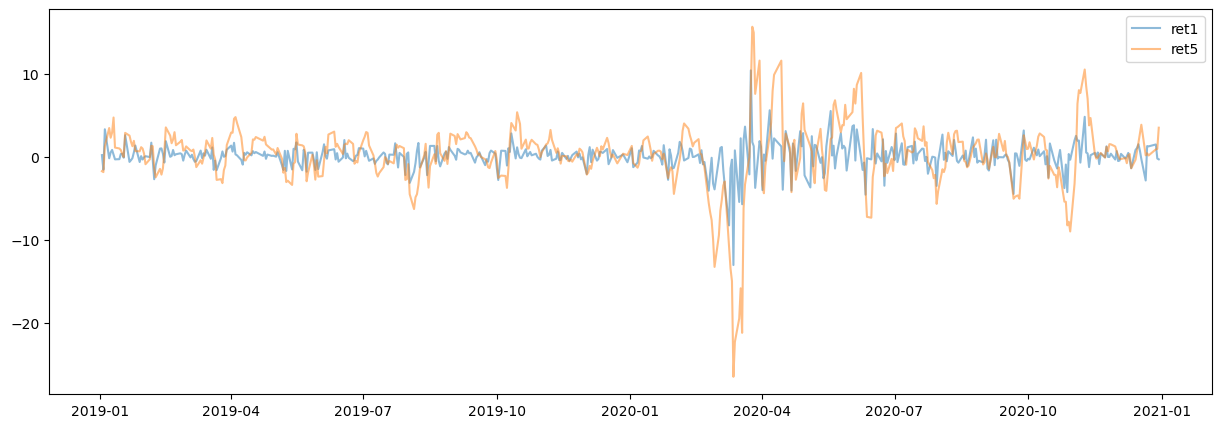

In [108]:
plt.figure(figsize=(15, 5))
plt.plot(filtered_df['ret1'], alpha=0.5, label='ret1')
plt.plot(filtered_df['ret5'], alpha=0.5, label='ret5')
plt.legend()
plt.show()

### Check Autocorrelation

/Users/yanting/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


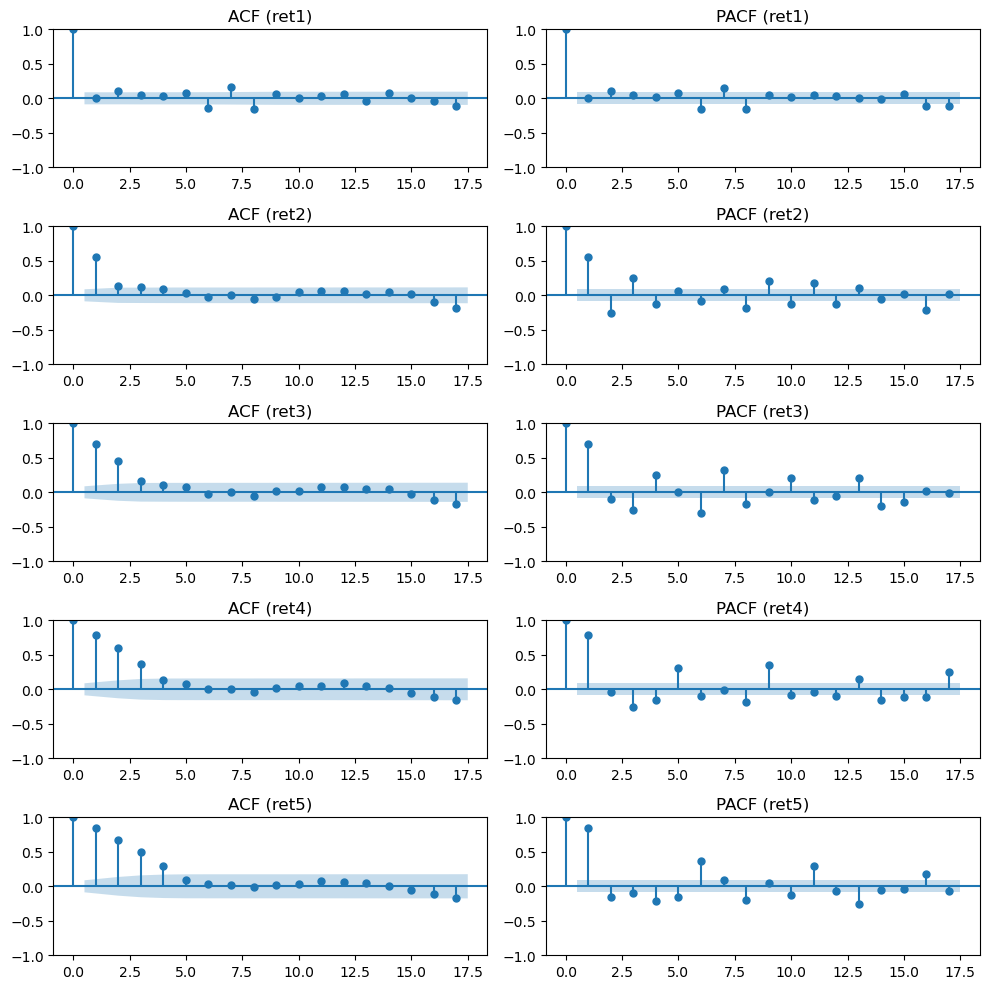

In [109]:
fig, axes = plt.subplots(5, 2 ,figsize=(10,10))

max_lag = 17
for i, horizon in enumerate(filtered_df.columns):
    plot_acf(filtered_df[horizon], lags=max_lag, ax=axes[i, 0], title=f"ACF ({horizon})")
    plot_pacf(filtered_df[horizon], lags=max_lag, ax=axes[i, 1], title=f"PACF ({horizon})")

plt.tight_layout()
plt.show()

# seems to be that as the horizon increases, the autocorrelation increases

# eg for the 2-period return ... the autocorrelation is high for lag=1
# which makes sense since the 2-period return should somehow depend on the period in between

# ret2(t) = price(t) - price(t-2) 
# ret2(t-1) = price(t-1) - price(t-3)
# ret2(t-2) = price(t-2) - price(t-4)

# but how exactly ...

# ret2(t) = price(t) - price(t-2) = price(t) - [ ret2(t-2) + price(t-4) ]
# -> so PACF(2) is negative

# ret2(t) = price(t) - price(t-2) = ... ret2(t-1) ???
# if ret2(t) was large, that means price rose from (t-2) to t
# which probably indicates that the price in (t-1) was also high
# -> so PACF(1) is positive

In [110]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Tests for absence of autocorrelation *WITHIN* k lags
# H0 = no autocorrelation
# p value low -> reject H0 -> probably some autocorrelation
# p value high -> cannot reject H0 -> probably no autocorrelation

# eg for ret1
# p values are quite high at low lags -> probably no autocorrelation
# as lags increase to 20, because we are testing the H0 of all autocorr simultaneously being = 0
# p values drop -> cannot reject that all of them are simultaneously = 0

# eg for ret5
# p value is already very small at lag=1 at 10^-80 -> reject H0 -> probably some autocorrelation
# it further decreases till lag=5 to 10^-150 -> probably some autocorrelation
# but up to lag=20 it remains at the order of 10^-150
# so the addition of more lags does not make the test reject more strongly, 
# meaning that the main component of autocorrelation is probably already captured by the first 5 lags

for i, horizon in enumerate(filtered_df.columns):

    # Perform Ljung-Box test against white noise
    lb_test = acorr_ljungbox(filtered_df[horizon], lags=[1, 2, 3, 4, 5, 20], return_df=True)

    # return max pval
    print(f"Ljung-Box test results for {horizon}:")
    print(lb_test)
    print('- '*15)


Ljung-Box test results for ret1:
      lb_stat     lb_pvalue
1    0.000430  9.834648e-01
2    5.754243  5.629657e-02
3    6.822119  7.778883e-02
4    7.434877  1.146155e-01
5   10.599133  5.993348e-02
20  66.721588  6.188412e-07
- - - - - - - - - - - - - - - 
Ljung-Box test results for ret2:
       lb_stat     lb_pvalue
1   154.744610  1.592226e-35
2   163.424991  3.256223e-36
3   170.558240  9.641606e-37
4   175.377164  7.331626e-37
5   175.781881  4.257161e-36
20  213.729321  2.122368e-34
- - - - - - - - - - - - - - - 
Ljung-Box test results for ret3:
       lb_stat     lb_pvalue
1   252.118373  8.966501e-57
2   355.534659  6.260798e-78
3   368.109121  1.787407e-79
4   373.245388  1.675248e-79
5   375.971555  4.465050e-79
20  424.346879  1.792390e-77
- - - - - - - - - - - - - - - 
Ljung-Box test results for ret4:
       lb_stat      lb_pvalue
1   312.776935   5.423712e-70
2   495.296143  2.804201e-108
3   561.593917  2.132322e-121
4   570.817030  3.203633e-122
5   574.070342  8.08617

### Fit ARIMA Model to each ret

In [111]:
# # do fits for all ret1 to ret5 and save the models in a dict
# models = {}

# for horizon in filtered_df.columns:

#     print('= '*15)
#     print(f"start {horizon}")
#     print('= '*15)
#     models[horizon] = pm.auto_arima(ret_df[horizon], start_p=1, start_q=1,
#                                     max_p=10, max_q=10, trace=True,
#                                     error_action='ignore',
#                                     suppress_warnings=True,
#                                     stepwise=True)

# # The stepwise approach follows the strategy laid out by Hyndman and Khandakar in their 2008 paper,
# # “Automatic Time Series Forecasting: The forecast Package for R”.

In [112]:
# horizon = 'ret5'
# models = {}

# models[horizon] = pm.auto_arima(ret_df[horizon], start_p=1, start_q=1,
#                                 max_p=10, max_q=10, trace=True,
#                                 error_action='ignore',
#                                 suppress_warnings=True,
#                                 stepwise=True)

# error = models['ret5'].fittedvalues() - ret_df['ret5']
# MSE = np.mean(error**2)
# print(f"MSE: {MSE}")

In [113]:
horizon = 'ret5'
models = {}

# Fit an ARMA(17, 2) model
models[horizon] = pm.ARIMA(order=(17, 0, 2)).fit(ret_df[horizon], trace=True)

/Users/yanting/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yanting/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yanting/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MSE: 2.373561751210281
MAE: 1.0844147666361823
SMAPE: 77.96887716419923


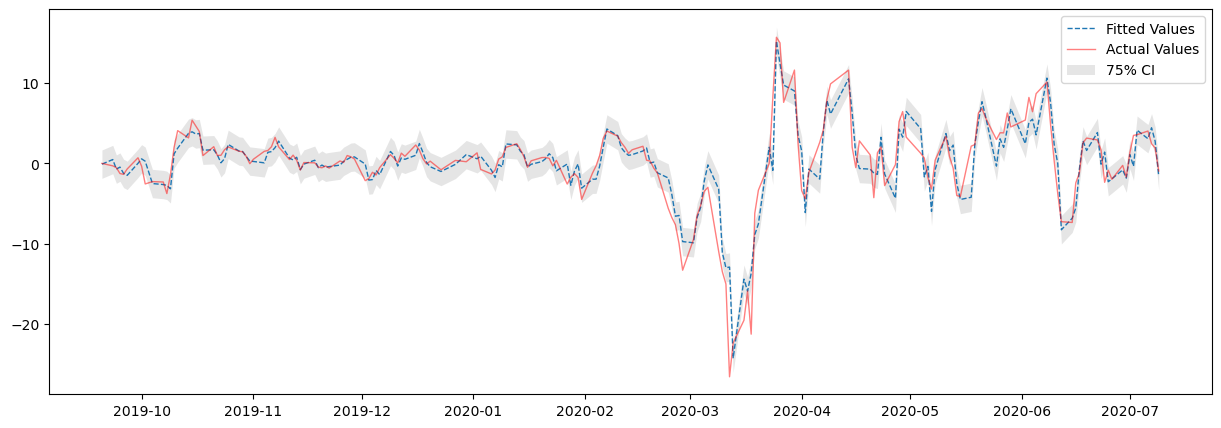

In [117]:
# Return MSE, MAE, SMAPE
error = models[horizon].fittedvalues() - ret_df[horizon]

MSE = np.mean(error**2)
MAE = np.mean(np.abs(error))
SMAPE = 2 * np.mean(np.abs(error) / (np.abs(ret_df[horizon]) + np.abs(fitted_values))) * 100

print(f"MSE: {MSE}")
print(f"MAE: {MAE}")
print(f"SMAPE: {SMAPE}")

# - - - - - - - - - - - - - - - - - -
# Get the fitted values and prediction intervals at level 1-alpha

alpha = 0.25
fitted_values = models[horizon].fittedvalues()
in_samp_pred, confints = models[horizon].predict_in_sample(return_conf_int=True, alpha=alpha)

# Plotting
plt.figure(figsize=(15, 5))

start = 5000 
len = 200
end = start + len

plt.plot(ret_df.index[start:end], fitted_values[start:end], label='Fitted Values', lw=1, ls='--')
plt.plot(ret_df.index[start:end], ret_df[horizon][start:end], alpha=0.5, label='Actual Values', lw=1, color='red')

plt.fill_between(ret_df.index[start:end], confints[:, 0][start:end], confints[:, 1][start:end], 
                 color='gray', alpha=0.2, lw=0, label=f'{(1-alpha)*100:.0f}% CI')

plt.legend()
plt.show()

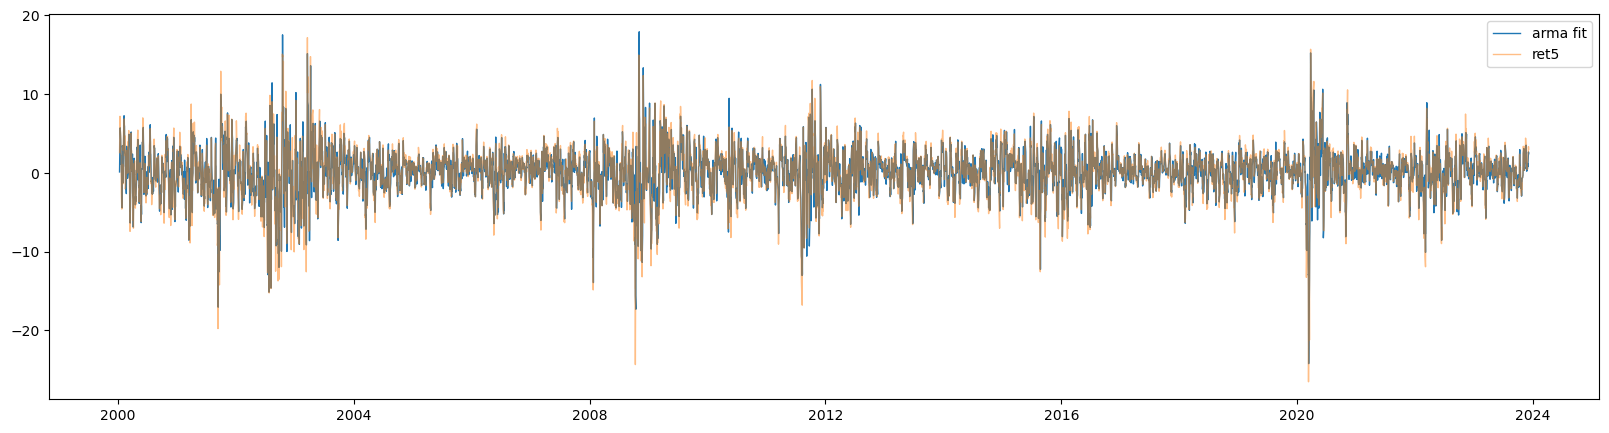

In [118]:
plt.figure(figsize=(20, 5))
plt.plot(ret_df.index, models[horizon].fittedvalues(), label='arma fit', lw=1)
plt.plot(ret_df[horizon], alpha=0.5, label=horizon, lw=1)
plt.legend()
plt.show()

### Fit GARCH Model (rpy2) ???

1) Fit a GARCH model on the residuals of the ARIMA model and add both contributions.

2) Fit both models simultaneously. This is the preferred way as otherwise, ARIMA estimates may be inconsistent.


In [ ]:
# Among other strategies probably the simplest, although computationally demanding one 
# would be to fix a pool of candidate models 
# (e.g. all submodels of ARMA(4,4)-GARCH(2,2)), estimate them (preferably simultaneously) 
# and select the one with the lowest AIC (if the goal is forecasting) 
# or lowest BIC (if the goal is recovering the "true" model).

# https://stats.stackexchange.com/a/252492/338210

In [119]:
import rpy2
import os
import platform
if 'win' in platform.platform():
    os.environ['R_HOME'] = 'C:\Program Files\R\R-4.3.2'

In [120]:
import rpy2.robjects as ro
import rpy2.robjects.pandas2ri as pandas2ri
from rpy2.robjects.conversion import localconverter

import rpy2.robjects.packages as rpackages
import rpy2.robjects as robjects

import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

In [ ]:
# # use R package ugarch to simultaneously fit ARIMA-GARCH model for ret1 to ret5
# # and save the models in a dict

# from itertools import product

# rugarch = rpackages.importr('rugarch')
# arma_garch_models = {}

# # Define the parameter space
# p_values = range(1,6)  # AR order
# q_values = range(1,6)  # MA order
# r_values = [1, 2]  # GARCH order
# s_values = [1, 2]  # ARCH order

# # Generate all combinations of parameters
# param_combinations = product(p_values, q_values, r_values, s_values)

# dist = 'norm'
# fix_df = 3
# r_std_params= robjects.ListVector({'shape': fix_df})

# for ret_horizon in ret_df.columns :

#     print('-' * 30)
#     print(f"start {ret_horizon}")
#     print('-' * 30)

#     # Convert the Pandas Series to an R vector
#     # r_resid = robjects.vectors.FloatVector(models[horizon].resid())
#     r_returns = robjects.vectors.FloatVector(ret_df[ret_horizon])

#     # Fit multiple models and choose the one with the smallest combined AIC and BIC
#     # try all combinations between ARMA(p,q) with p and q ranging from 0 to 5
#     # and both GARCH(1,1) and GARCH(2,2) models

#     best_aic_bic = float('inf')
#     best_model = None   

#     # Iterate over parameter combinations
#     for p, q, arch_p, arch_q in param_combinations:
    
#         print(f"start {p}, {q}, {arch_p}, {arch_q}")

#         mean_model = robjects.ListVector(
#             {'armaOrder': robjects.IntVector([p, q])})

#         variance_model = robjects.ListVector(
#             {'model': "sGARCH",
#             'garchOrder': robjects.IntVector([arch_p, arch_q])})
    
#         if dist == 'std':
#             model = rugarch.ugarchspec(variance_model=variance_model, mean_model=mean_model, distribution_model=dist, fixed_pars=r_std_params)

#         elif dist == "norm":
#             model = rugarch.ugarchspec(variance_model=variance_model, mean_model=mean_model, distribution_model=dist)

#         # model = rugarch.ugarchspec()
#         modelfit = rugarch.ugarchfit(spec=model, data=r_returns, solver='hybrid', tol=1e-3) 
#         # print(modelfit)

#         # Calculate the combined AIC and BICa
#         aic = rugarch.infocriteria(modelfit)[1][0]
#         bic = rugarch.infocriteria(modelfit)[2][0]
#         # print(f"aic = {aic}, bic = {bic}")

#         combined_aic_bic = aic + bic

#         # Update the best model if the current one is better
#         if combined_aic_bic < best_aic_bic:
#             print(f"-> new best model updated")
#             print(f"-> aic = {aic:.3f}, bic = {bic:.3f}")
#             best_aic_bic = combined_aic_bic
#             best_model = modelfit

#     # save model with smallest AIC+BIC
#     arma_garch_models[ret_horizon] = best_model
#     print('= ' * 15)


------------------------------
start ret1
------------------------------
start 1, 1, 1, 1
-> new best model updated
-> aic = 3.229, bic = 3.222
start 1, 1, 1, 2
start 1, 1, 2, 1
-> new best model updated
-> aic = 3.228, bic = 3.220
start 1, 1, 2, 2
start 1, 2, 1, 1
start 1, 2, 1, 2
start 1, 2, 2, 1
start 1, 2, 2, 2
start 1, 3, 1, 1
start 1, 3, 1, 2
start 1, 3, 2, 1
start 1, 3, 2, 2
start 1, 4, 1, 1
start 1, 4, 1, 2
start 1, 4, 2, 1
start 1, 4, 2, 2
start 1, 5, 1, 1
start 1, 5, 1, 2
start 1, 5, 2, 1
start 1, 5, 2, 2
start 2, 1, 1, 1
start 2, 1, 1, 2
start 2, 1, 2, 1
start 2, 1, 2, 2
start 2, 2, 1, 1
start 2, 2, 1, 2
start 2, 2, 2, 1
start 2, 2, 2, 2
start 2, 3, 1, 1
start 2, 3, 1, 2
start 2, 3, 2, 1
start 2, 3, 2, 2
start 2, 4, 1, 1
start 2, 4, 1, 2
start 2, 4, 2, 1
start 2, 4, 2, 2
start 2, 5, 1, 1
start 2, 5, 1, 2
start 2, 5, 2, 1
start 2, 5, 2, 2
start 3, 1, 1, 1
start 3, 1, 1, 2
start 3, 1, 2, 1
start 3, 1, 2, 2
start 3, 2, 1, 1
start 3, 2, 1, 2
start 3, 2, 2, 1
start 3, 2, 2, 2
sta

In [125]:
# fit one rugarch model as test

# use R package ugarch to simultaneously fit ARIMA-GARCH model for ret1 to ret5
# and save the models in a dict

rugarch = rpackages.importr('rugarch')

# Convert the Pandas Series to an R vector
r_returns = robjects.vectors.FloatVector(ret_df[horizon])

p = 17
q = 2
arch_p = 2
arch_q = 2

mean_model = robjects.ListVector(
    {'armaOrder': robjects.IntVector([p, q])})

variance_model = robjects.ListVector(
    {'model': "sGARCH",
    'garchOrder': robjects.IntVector([arch_p, arch_q])})

# Create and fit the GARCH specification
model = rugarch.ugarchspec(variance_model=variance_model, mean_model=mean_model, distribution_model='norm')
modelfit = rugarch.ugarchfit(spec=model, data=r_returns, solver='hybrid', tol=1e-3) 
print(modelfit)

# Calculate the combined AIC and BICa
aic = rugarch.infocriteria(modelfit)[1][0]
bic = rugarch.infocriteria(modelfit)[2][0]
print(f"aic = {aic}, bic = {bic}")


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(2,2)
Mean Model	: ARFIMA(17,0,2)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error    t value Pr(>|t|)
mu      0.378767    0.053225    7.11633 0.000000
ar1    -0.589708    0.012590  -46.83993 0.000000
ar2     0.532845    0.015186   35.08714 0.000000
ar3     0.798244    0.016512   48.34409 0.000000
ar4    -0.008184    0.018179   -0.45018 0.652580
ar5    -0.725943    0.019759  -36.73923 0.000000
ar6    -0.401973    0.018965  -21.19502 0.000000
ar7     0.376634    0.019794   19.02734 0.000000
ar8     0.525942    0.020813   25.26967 0.000000
ar9    -0.010583    0.019649   -0.53862 0.590148
ar10   -0.445731    0.021148  -21.07667 0.000000
ar11   -0.218177    0.020572  -10.60574 0.000000
ar12    0.215216    0.020815   10.33951 0.000000
ar13

MSE: 2.3920874303709527
MAE: 1.0777566093412494
SMAPE: 77.48481745247531


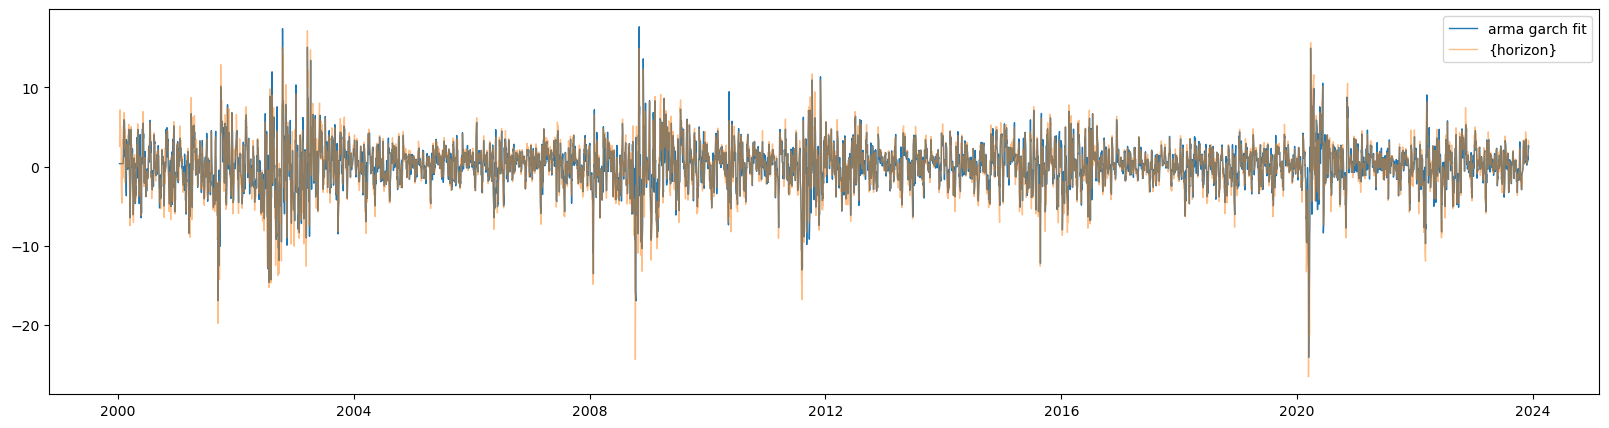

In [126]:
arma_garch_models[horizon] = modelfit

error = rugarch.fitted(arma_garch_models[horizon]).flatten() - ret_df[horizon]
MSE = np.mean(error**2)
MAE = np.mean(np.abs(error))
SMAPE = 2 * np.mean(np.abs(error) / (np.abs(ret_df[horizon]) + np.abs(fitted_values))) * 100

print(f"MSE: {MSE}")
print(f"MAE: {MAE}")
print(f"SMAPE: {SMAPE}")


plt.figure(figsize=(20, 5))
plt.plot(ret_df.index, rugarch.fitted(arma_garch_models[horizon]), label='arma garch fit', lw=1)
plt.plot(ret_df[horizon], alpha=0.5, label='{horizon}', lw=1)
plt.legend()
plt.show()

### Make ARIMA-GARCH fcast ???